# Demo de implementación de un Algoritmo Genético (AG) para resolver el problema de encontrar los exponentes de números primos para aproximar a un número determinado
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [1]:
#@title
!pip install deap

1) Importar librerías:

In [2]:
#@title 
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from deap import base
from deap import creator
from deap import tools

print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [3]:
# el número a aproximar
VALOR_A_APROXIMAR =  66#@param {type:"integer"}

# parámetros para el cromosoma
VALORES_PRIMOS = "2,3,5,7,11,13" #@param {type:"string"}
PRIMOS_CON_EXPONENTE = [int(v) for v in VALORES_PRIMOS.split(",")]

VALOR_MAXIMO_EXPONENTE = 3 #@param {type:"integer"}

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100 #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 15  #@param {type:"slider", min:1, max:100, step:1}

# Probabilidad del Mutación 
PROBAB_MUTACION = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


2) Inicializar objetos de DEAP para utilizar e indicar Operadores Genéticos:

In [4]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

## OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Ranking' #@param ["Azar", "Torneo", "Ranking", "Ruleta", "Control s/Numero Esperado"]
tipo_cruzamiento = 'Simple-2Puntos' #@param ["Simple-1Punto", "Simple-2Puntos", "Azar"]

# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Control s/Número Esperado':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
if tipo_cruzamiento == 'Simple-1Punto':
  toolbox.register("mate", tools.cxOnePoint)
elif tipo_cruzamiento == 'Simple-2Puntos':
  toolbox.register("mate",  tools.cxTwoPoint)  
else:
  toolbox.register("mate", tools.cxUniform, indpb=0.5)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", tools.mutUniformInt, low=0, up=VALOR_MAXIMO_EXPONENTE, indpb=0.2)

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


3) Especificar Estructura del Cromosoma y Función de Aptitud:

In [5]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))

# definimos la función de aptitud a evaluar
def funcAptitud(individuo):

    # calcula el número que corresponde al individuo
    valorIndividuo = formatearIndividuo(individuo, False)
    
    # determina la aptitud 
    # como la difencia entre 100% 
    # y el negativo del error relativo
    # del valor a aproximar y el del indiviudo
    # (el mejor debería ser 100%)
    if VALOR_A_APROXIMAR != 0:
      errorRelativo = abs(VALOR_A_APROXIMAR - valorIndividuo) / VALOR_A_APROXIMAR      
    else:
      errorRelativo = abs(VALOR_A_APROXIMAR - valorIndividuo) / 0.00001
    aptitud = 100.0 - (errorRelativo*100.0)

    return aptitud,

# función para mostrar individuo
def formatearIndividuo(individuo, devStr=True):
    
    # calcula el número que corresponde al individuo
    strIndividuo = ""
    valorIndividuo = 1
    for i in range(len(individuo)):
      p = PRIMOS_CON_EXPONENTE[i]
      valorIndividuo = valorIndividuo * ( p ** individuo[i] )
      if i > 0:
        strIndividuo = strIndividuo + " x "
      strIndividuo = strIndividuo + str(p) + "^" + str(individuo[i])
    
    # determina el resultado
    if devStr:
      res = strIndividuo + " = " + str(valorIndividuo)
    else:
      res = valorIndividuo
    return res

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# indica que los genes son int correspondiente a las exponentes a encontrar
toolbox.register("attr_int", random.randint, 0, VALOR_MAXIMO_EXPONENTE) 

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, len(PRIMOS_CON_EXPONENTE)) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("\nCromosoma definido")


Función de Aptitud definida

Cromosoma definido


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [6]:
#@title EJECUCIÓN DE LA CORRIDA


## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud

    if len(indivPobla) == 0:
      return None, 0, 0, 0 

    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    
    for ind in indivPobla:

        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt

        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt

    auxProm = round(auxSum / len(indivPobla),2)

    if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
          mejorIndCorrida = auxBestInd
          mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )

    if muestra:          
        print("\n-- Ciclo  %i --" % ciclo)
        print(" Mejor Individuo:", formatearIndividuo(auxBestInd), " {", auxBestIndApt, "}")
        print("   Max: ", auxMax, " / Promedio: ", auxProm, " / Min: ", auxMin)

    return auxBestInd, auxMax, auxProm, auxMin


# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = 100
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")

# vectores auxiliares 
ciclo = 1    
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = list(map(toolbox.evaluate, indivPobla))
for ind, fit in zip(indivPobla, fitnesses):
    ind.fitness.values = fit

ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos 
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, len(indivPobla))

    # Inicializa a los hijos clonando a los seleccionados
    indivHijos = list(map(toolbox.clone, indivSelecc))
    
    # Realiza el Cruzamiento
    for hijo1, hijo2 in zip(indivHijos[::2], indivHijos[1::2]):
            toolbox.mate(hijo1, hijo2)
            del hijo1.fitness.values
            del hijo2.fitness.values

    # Realiza la Mutación
    for mutant in indivHijos:
        if random.random() < PROBAB_MUTACION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            break # solo muta 1 vez por vuelta
              
    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )
    
    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("** Valor a Aproximar: ", VALOR_A_APROXIMAR, " **")
print("== Mejor Individuo de la Corrida:", formatearIndividuo(mejorIndCorrida), " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")

-- Mínima heurística para finalizar la Corrida:  100 --

-- Ciclo  0 --
 Mejor Individuo: 2^1 x 3^1 x 5^0 x 7^1 x 11^0 x 13^0 = 42  { 63.64 }
   Max:  63.64  / Promedio:  -17291643053.54  / Min:  -248678429800.0

-- Ciclo  1 --
 Mejor Individuo: 2^1 x 3^0 x 5^0 x 7^0 x 11^0 x 13^0 = 2  { 3.03 }
   Max:  3.03  / Promedio:  -24256835159.09  / Min:  -248678429800.0

-- Ciclo  2 --
 Mejor Individuo: 2^1 x 3^0 x 5^0 x 7^1 x 11^0 x 13^0 = 14  { 21.21 }
   Max:  21.21  / Promedio:  -40450975307.17  / Min:  -350700349800.0

-- Ciclo  3 --
 Mejor Individuo: 2^1 x 3^0 x 5^0 x 7^0 x 11^0 x 13^0 = 2  { 3.03 }
   Max:  3.03  / Promedio:  -32438497859.49  / Min:  -350700349800.0

-- Ciclo  4 --
 Mejor Individuo: 2^0 x 3^3 x 5^0 x 7^0 x 11^0 x 13^0 = 27  { 40.91 }
   Max:  40.91  / Promedio:  -55269067167.58  / Min:  -414464049800.0

-- Ciclo  5 --
 Mejor Individuo: 2^0 x 3^0 x 5^1 x 7^1 x 11^0 x 13^0 = 35  { 53.03 }
   Max:  53.03  / Promedio:  -332169262571.62  / Min:  -4559104549800.0

-- Ciclo  6

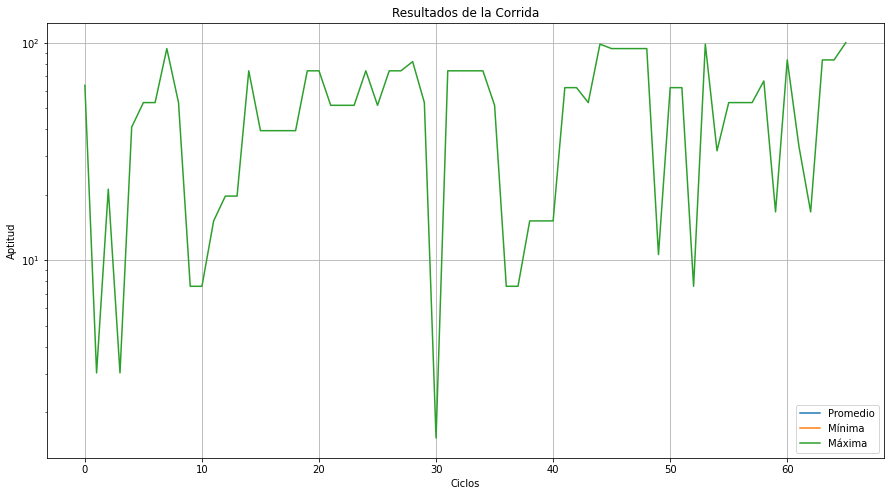

In [8]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
USAR_ESCALA_LOG = True #@param {type:"boolean"}
if USAR_ESCALA_LOG:
  plt.yscale('log')
plt.show()
